In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_theme(style="white", palette="muted")
sns.set_context("paper", font_scale = 1.3)

import warnings

# Supress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
from matplotlib.patches import Patch, Circle

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

from scipy import stats
from scipy import spatial
import pandas as pd
import numpy as np

from sklearn.covariance import MinCovDet, EmpiricalCovariance
from statsmodels.stats.multitest import fdrcorrection

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.config import get_interim_dir
from src.visualization import defaults

In [3]:
rename_mutations = {
    "Any Insertion": "Ins",
    "Deletion 0bp microhomology": "NoMHDel",
    "Deletion 1bp microhomology": "1bpMHDel",
    "Deletion 2bp microhomology": "2bpMHDel",
    "Deletion 3+bp microhomology": "3+bpMHDel",
    "Deletion with insertion": "Delins",
    "Homology Directed Repair": "HDR" 
}

In [4]:
alias = "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"

print(get_interim_dir())

X = pd.read_pickle(get_interim_dir() + "{}_gRNAwise_reduced_repair_outcome_profiles.pkl".format(alias))

idx = X.index.to_frame().reset_index(drop=True)
idx.loc[idx["Gene"] == "Non", "Gene"] = idx.loc[idx["Gene"] == "Non", "Barcode"]

X.index = pd.MultiIndex.from_frame(idx)

# adamson dataset has multiple "transcripts" for some genes. Remove the duplicates, as I am not sure what impact these "transcripts" have or if its a good idea to aggregate them together
transcripts = {}
for i, r in X.reset_index()[["Gene", "Transcript"]].iterrows():
    if r["Gene"] not in transcripts:
        transcripts[r["Gene"]] = r["Transcript"]

X = X.loc[X.reset_index().apply(lambda x: x["Transcript"] == transcripts[x["Gene"]], axis=1).to_list(), :].droplevel(3)

X = X.loc[:, (X != 0).any(axis=0)]
print((X>0).sum().sum() / (X.shape[0] * X.shape[1]))

counts = X.sum(axis=1)

X_orig = X.copy()

X = X.div(X.sum(axis=1), axis=0)
columns = X.columns
X = X.groupby(["Gene"]).mean()
X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)

X = X.rename(columns=rename_mutations)

/Users/colm/repos/MUSICian/data/interim/
0.9993145990404386


In [5]:
X = impute_zero_values(X, 1)

0.00 of our data is zero


In [6]:
X = X[X.columns.sort_values()]

In [7]:
Xt = X[~X.index.str.contains("non-")].copy()
Xnt = X[X.index.str.contains("non-")].copy()

In [8]:
Xnt.shape

(60, 7)

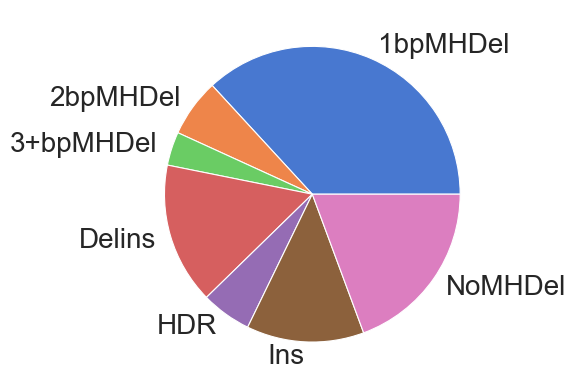

In [9]:
plt.figure()
Xnt.iloc[0, :].plot.pie()
plt.ylabel(None)
plt.show()

In [10]:
Xnt.iloc[0, :]

lumc_category
1bpMHDel     0.368427
2bpMHDel     0.063319
3+bpMHDel    0.036677
Delins       0.154538
HDR          0.055027
Ins          0.128470
NoMHDel      0.193544
Name: non-targeting_00026, dtype: float64

In [11]:
Xt.loc["Xrcc5"]

lumc_category
1bpMHDel     0.298442
2bpMHDel     0.050420
3+bpMHDel    0.042809
Delins       0.162816
HDR          0.059693
Ins          0.207723
NoMHDel      0.178096
Name: Xrcc5, dtype: float64

Text(0, 0.5, '')

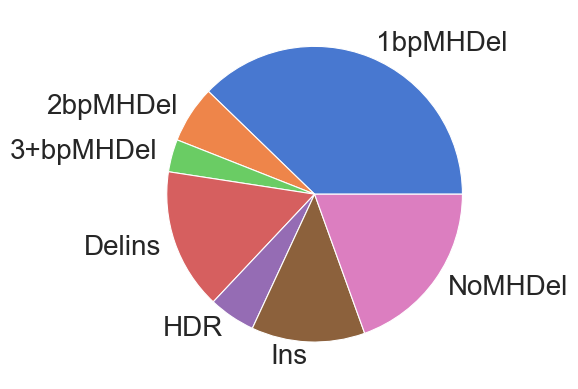

In [12]:
plt.figure()
Xt.loc["Xrcc4"].plot.pie()
plt.ylabel(None)

Text(0, 0.5, '')

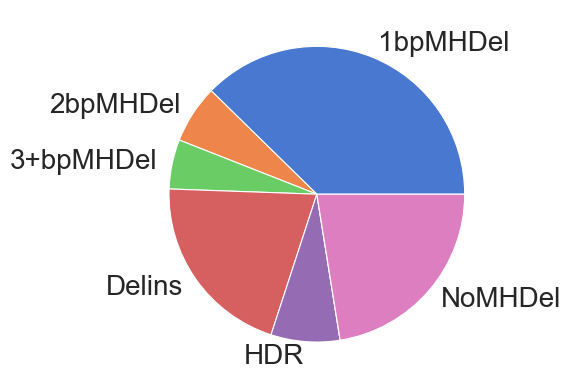

In [13]:
plt.figure()
fake_example = Xt.loc["Xrcc5"].copy()
fake_example["Ins"] = 0
fake_example.plot.pie()
plt.ylabel(None)

Text(0, 0.5, '')

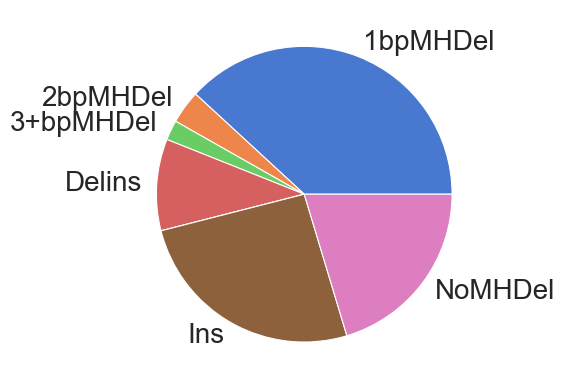

In [14]:
plt.figure()
fake_example = Xt.loc["Mre11a"].copy()
fake_example["HDR"] = 0
fake_example.plot.pie()
plt.ylabel(None)


[0.36999514 0.06183531 0.03726321 0.15203195 0.04680139 0.13366911
 0.1984039 ]
[0.36990625 0.06116002 0.03632658 0.15675011 0.04983516 0.12896519
 0.19705669]
[0.37196462 0.061807   0.03709766 0.15147219 0.04489961 0.13342595
 0.19933297]
[0.36985472 0.06111056 0.036318   0.15690724 0.04978157 0.12884237
 0.19718554]
Min 0.003261539394313622


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/3654967455.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


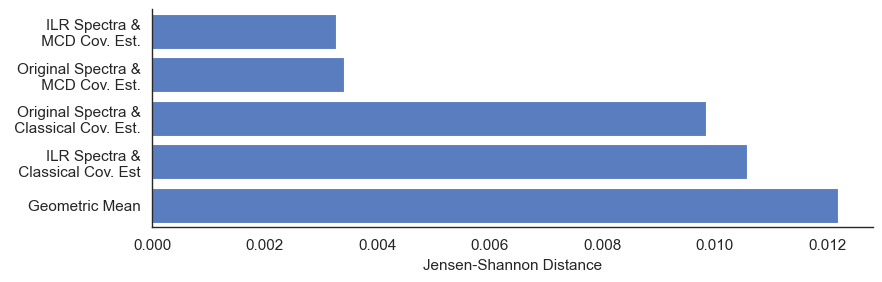

In [ ]:
from skbio.stats.composition import ilr_inv, ilr
pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
    outlier_detection(X, EmpiricalCovariance())
pca_central_freq = ss.inverse_transform(cov.location_[np.newaxis,:])[0]
print(pca_central_freq)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
        outlier_detection(X, MinCovDet(random_state=0))
    robust_pca_central_freq = ss.inverse_transform(cov.location_[np.newaxis,:])[0]
    print(robust_pca_central_freq)


pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(X, EmpiricalCovariance())
ilr_pca_central_freq = ilr_inv(cov.location_[np.newaxis,:])
print(ilr_pca_central_freq)

pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(X, MinCovDet(random_state=0))
ilr_robust_central_freq = ilr_inv(cov.location_[np.newaxis,:])
print(ilr_robust_central_freq)

from scipy.spatial.distance import cdist

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(Xt), index=X.columns)
gmean_mahal_only = pd.Series(pca_central_freq, index=Xnt.columns)
gmean_robust = pd.Series(robust_pca_central_freq, index=Xnt.columns)
gmean_ilr_mahal = pd.Series(ilr_pca_central_freq, index=Xnt.columns)
gmean_psuedo = pd.Series(ilr_robust_central_freq, index=Xnt.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    "No Pseudo-Control Selection (All Spectra)",
    "Original Spectra &\n Classical Cov. Est.",
    "Original Spectra &\n MCD Cov. Est.",
    "ILR Spectra &\n Classical Cov. Est",
    "ILR Spectra &\n MCD Cov. Est.",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
jsds = pd.concat([compare_df, distance_series], axis=1)
jsds = jsds.sort_values("Distance")


def plot_jsds(ax, jsds, fontsize=11):
    sns.barplot(ax=ax, data=jsds["Distance"].reset_index(), x="Distance", y="index", color=sns.color_palette()[0])
    ax.set_ylabel(None)
    ax.set_xlabel("Jensen-Shannon Distance", fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)
    print("Min",  np.min(jsds["Distance"]))


fig, ax = plt.subplots(figsize=(9, 3))
plot_jsds(ax, jsds)
plt.tight_layout()
plt.show()

Comparing distances for non-targeting samples 60
Min 0.00332390582975166


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/3654967455.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


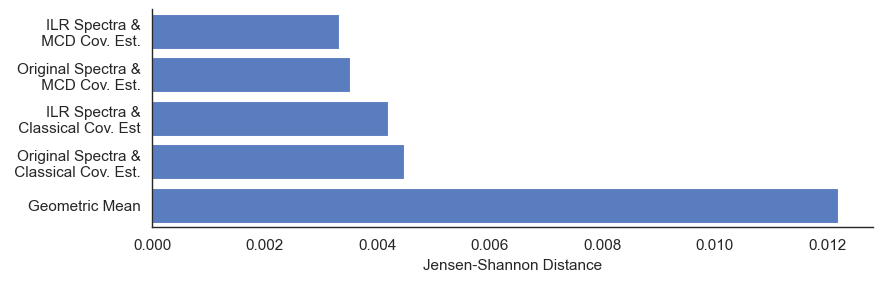

In [ ]:
from skbio.stats.composition import ilr_inv, ilr
pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
    outlier_detection(X, EmpiricalCovariance())
g1 = pd.Series(distances, index=X.index).sort_values()[:100].index

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss, cov = \
        outlier_detection(X, MinCovDet(random_state=0))
    g2 = pd.Series(distances, index=X.index).sort_values()[:100].index


pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(X, EmpiricalCovariance())
g3 = pd.Series(distances, index=X.index).sort_values()[:100].index

pca_scores, loadings, explained_variance_ratio, distances, pvalues, cov = \
    logratio_outlier_detection(X, MinCovDet(random_state=0))
g4 = pd.Series(distances, index=X.index).sort_values()[:100].index

from scipy.spatial.distance import cdist

print("Comparing distances for non-targeting samples", Xnt.shape[0])

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(Xt), index=X.columns)
gmean_mahal_only = pd.Series(stats.mstats.gmean(X.loc[g1]), index=Xnt.columns)
gmean_robust = pd.Series(stats.mstats.gmean(X.loc[g2]), index=Xnt.columns)
gmean_ilr_mahal = pd.Series(stats.mstats.gmean(X.loc[g3]), index=Xnt.columns)
gmean_psuedo = pd.Series(stats.mstats.gmean(X.loc[g4]), index=Xnt.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    # "Geometric Mean",
    # "Classical",
    # "Robust",
    # "ILR-Classical",
    # "ILR-Robust",
    "No Pseudo-Control Selection (All Spectra)",
    "Original Spectra &\n Classical Cov. Est.",
    "Original Spectra &\n MCD Cov. Est.",
    "ILR Spectra &\n Classical Cov. Est",
    "ILR Spectra &\n MCD Cov. Est.",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
jsds_psuedo_controls = pd.concat([compare_df, distance_series], axis=1)
jsds_psuedo_controls = jsds_psuedo_controls.sort_values("Distance")


fig, ax = plt.subplots(figsize=(9, 3))
plot_jsds(ax, jsds_psuedo_controls)
plt.tight_layout()
plt.show()

In [17]:
X.loc[X.index.str.contains("non-targeting")].shape

(60, 7)

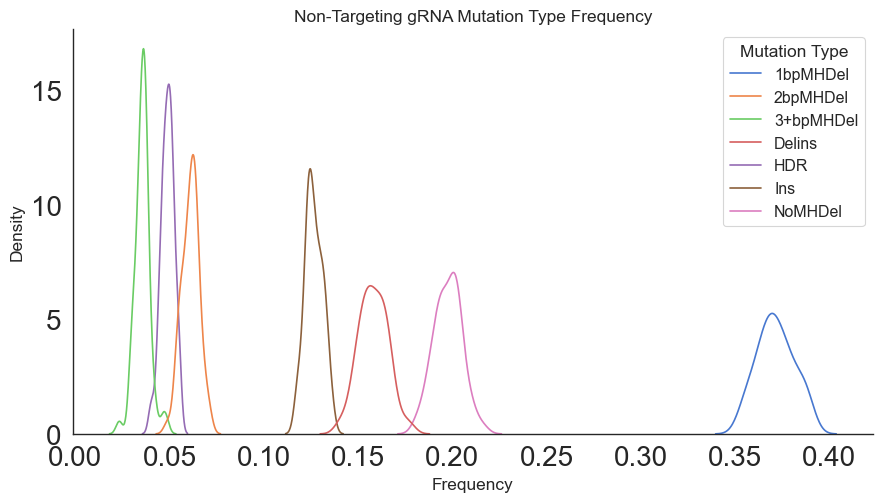

In [18]:
plt.figure(figsize=(9, 5))
sns.kdeplot(data = X.loc[X.index.str.contains("non-targeting")].stack().reset_index().rename(columns={"lumc_category": "Mutation Type", 0: "Frequency"}), \
            x = "Frequency", hue="Mutation Type")
plt.tight_layout()
plt.title("Non-Targeting gRNA Mutation Type Frequency")
plt.savefig("artifacts/mutation_type_kdeplot.pdf", bbox_inches='tight')


In [19]:
np.corrcoef(ilr(X).T).shape

(6, 6)

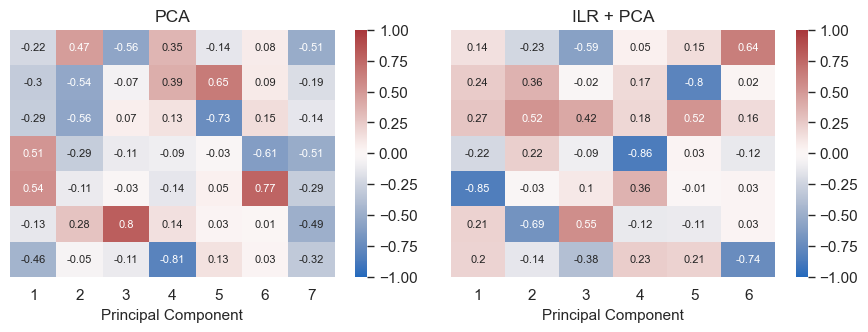

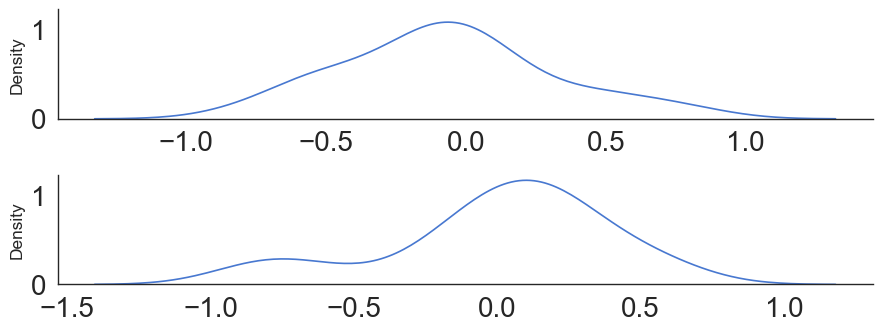

In [20]:
def heatmap(ax, X, cov, outlier_detection, annot=True, fontsize=11):
    results = outlier_detection(X, cov)
    score, coeff = results[:2]
    num_pc = coeff.shape[1]
    pc_list = [str(i) for i in list(range(1, num_pc+1))]
    loadings_df = pd.DataFrame(coeff, columns=pc_list, index=X.columns)

    g = sns.heatmap(loadings_df.round(2), annot=annot, cmap='vlag', ax = ax, annot_kws={"fontsize": 8}, center=0, vmin=-1, vmax=1)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fontsize)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fontsize)
    ax.set_xlabel("Principal Component", fontsize=fontsize)
    ax.set_ylabel(None)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    return results



fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True, sharex=False)

r1 = heatmap(ax[0], X, EmpiricalCovariance(), outlier_detection)
ax[0].set_title("PCA")
r2 = heatmap(ax[1], X, EmpiricalCovariance(), logratio_outlier_detection)
ax[1].set_title("ILR + PCA")

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(2, 1, figsize=(9, 3.5), sharey=True, sharex=False)
l1 = r1[1]
l2 = r2[1]
sns.kdeplot(np.ndarray.flatten(l1), ax=ax[0])
sns.kdeplot(np.ndarray.flatten(l2), ax=ax[1])

plt.tight_layout()
plt.show()


In [21]:
X

lumc_category,1bpMHDel,2bpMHDel,3+bpMHDel,Delins,HDR,Ins,NoMHDel
Gene,,,,,,,
Actl6a,0.370329,0.056800,0.035505,0.146207,0.041412,0.161979,0.187768
Actr5,0.370320,0.048522,0.032552,0.160077,0.047616,0.144957,0.195956
Actr8,0.374125,0.055238,0.030130,0.152400,0.053197,0.131315,0.203595
Aicda,0.369058,0.063038,0.035013,0.159269,0.051447,0.127185,0.194990
Alkbh2,0.370139,0.063219,0.036366,0.155689,0.054724,0.126305,0.193559
...,...,...,...,...,...,...,...
non-targeting_03451,0.388750,0.063098,0.031491,0.147185,0.051012,0.120193,0.198270
non-targeting_03460,0.390905,0.048927,0.023393,0.177828,0.044109,0.124993,0.189845
non-targeting_03512,0.382563,0.058586,0.039205,0.146396,0.047065,0.133481,0.192705


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax10.set_xticklabels(ax10.get_xticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax10.set_yticklabels(ax10.get_yticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax11.set_xticklabels(ax11.get_xticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax11.set_yticklabels(ax11.get_yticklabels(), fontsize=14)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case

Original Spectra &
 Classical Cov. Est.
(60, 7)
Euclidean Distance: 0.420577
Original Spectra &
 MCD Cov. Est.


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.838019749026252 > -52.856182548739717). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.035494587076030 > -54.880682442996580). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-53.035494587076030 > -53.187365487572606). You may want to try with a higher value of su

(60, 7)
Euclidean Distance: 0.403053
ILR Spectra &
 Classical Cov. Est.
(60, 7)
Euclidean Distance: 0.111001
ILR Spectra &
 MCD Cov. Est.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(60, 7)
Euclidean Distance: 0.008263
Min 0.00332390582975166


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/906739830.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/3654967455.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


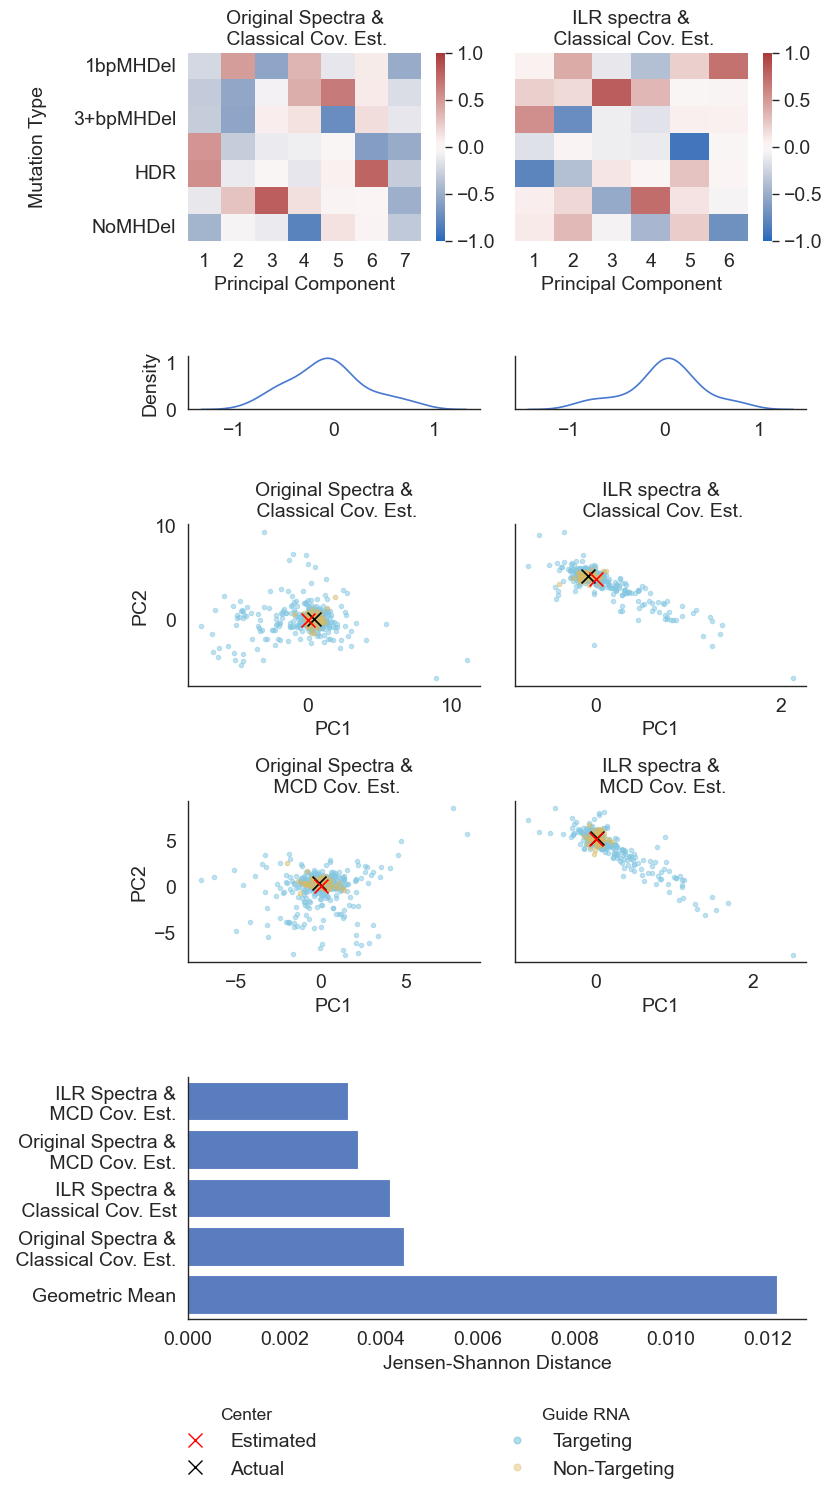

In [22]:
from scipy.stats import multivariate_normal

# Create a biplot
def biplot(ax, X, cov, outlier_detection):
    results = outlier_detection(X, cov)
    score, coeff = results[:2]
    covariance_ = results[-1].covariance_
    labels = X.columns

    score_nt = score[X.index.str.contains("non-")]
    score_t = score[~X.index.str.contains("non-")]

    print(score_nt.shape)

    # Get Seaborn color palette
    colors = sns.color_palette()

    # plot spectra
    ax.scatter(score_t[:, 0], score_t[:, 1], alpha=0.5, c=colors[9], s=10)
    ax.scatter(score_nt[:, 0], score_nt[:, 1], alpha=0.5, c=colors[8], s=10)


    # plot arrows
    # for i in range(len(coeff)):
    #     scaling_factor = score.max().max()
    #     ax.arrow(0, 0, coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor,\
    #             color=colors[7], linewidth=1, head_width=scaling_factor*0.05, alpha=0.5)
        # ax.text(coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor, labels[i], color=colors[7],
                # ha='center', va='top') 
    
    # plot centers
    ax.scatter(score_nt[:, 0].mean(), score_nt[:, 1].mean(), marker='x', color='black', s=100)  
    ax.scatter(0, 0, marker='x', color='red', s=100)  

    a = np.array((0, 0))
    b = np.array((score_nt[:, 0].mean(), score_nt[:, 1].mean()))
    print("Euclidean Distance: {:3f}".format(np.linalg.norm(a - b)))

    # plot contours
    # pc1absmax = np.max(np.abs(score_t[:,0]))
    # pc2absmax = np.max(np.abs(score_t[:,1]))
    # x, y = np.mgrid[-pc1absmax:pc1absmax:.01, -pc2absmax:pc2absmax:.01]
    # rv = multivariate_normal([0, 0], [covariance_[0,[0,1]], covariance_[0,[0,1]][::-1]])
    # data = np.dstack((x, y))
    # z = rv.pdf(data)
    # ax.contour(x, y, z)

    ax.set_xlabel("PC1", fontsize=14)
    ax.set_ylabel("PC2", fontsize=14)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


fig = plt.figure(figsize=(8.5, 14))

AX = mpl.gridspec.GridSpec(5, 2, height_ratios=[3.5, 1, 3, 3, 4.5])

ax00 = plt.subplot(AX[0, 0])
ax01 = plt.subplot(AX[0, 1])
ax10 = plt.subplot(AX[1, 0])
ax11 = plt.subplot(AX[1, 1])
ax1 = plt.subplot(AX[2, 0])
ax2 = plt.subplot(AX[2, 1])
ax3 = plt.subplot(AX[3, 0])
ax4 = plt.subplot(AX[3, 1])
ax5 = plt.subplot(AX[4, :])

r1 = heatmap(ax00, X, EmpiricalCovariance(), outlier_detection, annot=False, fontsize=14)
r2 = heatmap(ax01, X, MinCovDet(random_state=0), logratio_outlier_detection, annot=False, fontsize=14)


# KDE plot
l1 = r1[1]
l2 = r2[1]
kde1 = sns.kdeplot(np.ndarray.flatten(l1), ax=ax10)
ax10.set_xticklabels(ax10.get_xticklabels(), fontsize=14)
ax10.set_yticklabels(ax10.get_yticklabels(), fontsize=14)
ax10.set_ylabel(ax10.get_ylabel(), fontsize=14)
kde2 = sns.kdeplot(np.ndarray.flatten(l2), ax=ax11)
ax11.set_xticklabels(ax11.get_xticklabels(), fontsize=14)
ax11.set_yticklabels(ax11.get_yticklabels(), fontsize=14)
ax11.set_ylabel(ax10.get_ylabel(), fontsize=14)

# PCA
print("Original Spectra &\n Classical Cov. Est.")
biplot(ax1, X, EmpiricalCovariance(), outlier_detection)
print("Original Spectra &\n MCD Cov. Est.")
biplot(ax3, X, MinCovDet(random_state=0), outlier_detection)
print("ILR Spectra &\n Classical Cov. Est.")
biplot(ax2, X, EmpiricalCovariance(), logratio_outlier_detection)
print("ILR Spectra &\n MCD Cov. Est.")
biplot(ax4, X, MinCovDet(random_state=0), logratio_outlier_detection)

# JSDs
plot_jsds(ax5, jsds_psuedo_controls, fontsize=14)

#titles
ax00.set_title("Original Spectra &\n Classical Cov. Est.", fontsize=14)
ax01.set_title("ILR spectra &\n Classical Cov. Est.", fontsize=14)



ax1.set_title("Original Spectra &\n Classical Cov. Est.", fontsize=14)
ax2.set_title("ILR spectra &\n Classical Cov. Est.", fontsize=14)
ax3.set_title("Original Spectra &\n MCD Cov. Est.", fontsize=14)
ax4.set_title("ILR spectra &\n MCD Cov. Est.", fontsize=14)

# ax00.text(-0.44, 1.1, "A", transform=ax00.transAxes, 
#             size=16, weight='bold')
# ax10.text(-0.34, 1.1, "B", transform=ax10.transAxes, 
#             size=16, weight='bold')
# ax1.text(-0.34, 1.1, "C", transform=ax1.transAxes, 
#             size=16, weight='bold')
# ax5.text(-0.17, 1.1, "D", transform=ax5.transAxes, 
#             size=16, weight='bold')

# labels
ax00.set_ylabel("Mutation Type\n", fontsize=14)
# ax00.set_xlabel(None)
# ax01.set_xlabel(None)
ax01.set_ylabel(None)
ax11.set_ylabel(None)

for axi in [ax01, ax11, ax2, ax4]:
    plt.setp(axi.get_yticklabels(), visible=False)
    axi.set_ylabel(None)

from matplotlib.lines import Line2D
colors = sns.color_palette()

legend_labels2 = ["Targeting", "Non-Targeting"]
legend_handles2 = [Line2D([0], [0], marker='o', linewidth=0, color=colors[i+8][::-1], alpha=0.5) for i in range(2)]
lgd2 = fig.legend(legend_handles2, legend_labels2, loc='lower center', ncol=1, title='Guide RNA', fontsize=14, frameon=False,\
            bbox_to_anchor=(0.7, -0.075))

legend_labels1 = ["Estimated", "Actual"]
legend_handles1 = [Line2D([0], [0], marker='x', linewidth=0, color=c, markersize=10) for c in ["red", "black"]]
lgd1 = fig.legend(legend_handles1, legend_labels1, loc='lower center', ncol=1, title='Center', fontsize=14, frameon=False,\
            bbox_to_anchor=(0.3, -0.075))


plt.tight_layout()
plt.savefig("artifacts/repair-seq-pca.svg", bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


PCA
Robust PCA


/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.676545291543050 > -54.085227660551489). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54.533529197926384 > -56.037809452754807). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust

ILR + PCA
ILR + Robust PCA


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_33071/3654967455.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize)


Min 0.00332390582975166


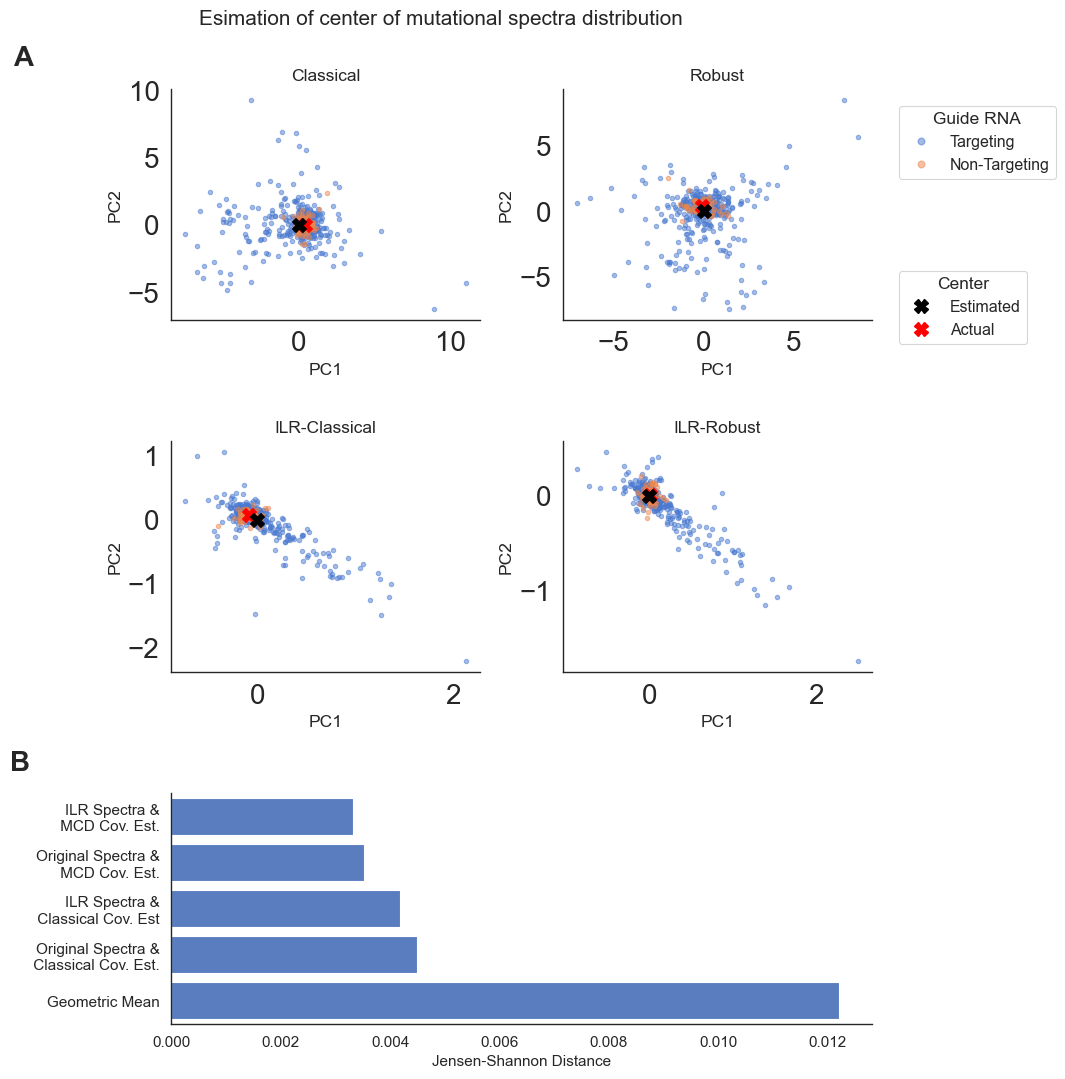

In [23]:
from scipy.stats import multivariate_normal

# Create a biplot
def biplot(ax, X, cov, outlier_detection):
    results = outlier_detection(X, cov)
    score, coeff = results[:2]
    covariance_ = results[-1].covariance_
    labels = X.columns

    score_nt = score[X.index.str.contains("non-")]
    score_t = score[~X.index.str.contains("non-")]

    # Get Seaborn color palette
    colors = sns.color_palette()

    # plot spectra
    ax.scatter(score_t[:, 0], score_t[:, 1], alpha=0.5, c=colors[0], s=10)
    ax.scatter(score_nt[:, 0], score_nt[:, 1], alpha=0.5, c=colors[1], s=10)


    # plot arrows
    # for i in range(len(coeff)):
    #     scaling_factor = score.max().max()
    #     ax.arrow(0, 0, coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor,\
    #             color=colors[7], linewidth=1, head_width=scaling_factor*0.05, alpha=0.5)
        # ax.text(coeff[i, 0] * scaling_factor, coeff[i, 1] * scaling_factor, labels[i], color=colors[7],
        #         ha='center', va='top') 
    
    # plot centers
    ax.scatter(score_nt[:, 0].mean(), score_nt[:, 1].mean(), marker='X', color='red', s=100)  
    ax.scatter(0, 0, marker='X', color='black', s=100)  

    # plot contours
    # pc1absmax = np.max(np.abs(score_t[:,0]))
    # pc2absmax = np.max(np.abs(score_t[:,1]))
    # x, y = np.mgrid[-pc1absmax:pc1absmax:.01, -pc2absmax:pc2absmax:.01]
    # rv = multivariate_normal([0, 0], [covariance_[0,[0,1]], covariance_[0,[0,1]][::-1]])
    # data = np.dstack((x, y))
    # z = rv.pdf(data)
    # ax.contour(x, y, z)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")


fig = plt.figure(figsize=(9, 11))

# ax0 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# g = sns.kdeplot(data=Xnt.stack()\
#     .reset_index()\
#     .rename(columns={"Gene": "", "lumc_category": "Mutation Type", 0: "Frequency"}), 
#     x="Frequency", hue="Mutation Type", common_norm=True, ax=ax0, legend=False)

print("PCA")
biplot(ax1, X, EmpiricalCovariance(), outlier_detection)
print("Robust PCA")
biplot(ax2, X, MinCovDet(random_state=0), outlier_detection)
print("ILR + PCA")
biplot(ax3, X, EmpiricalCovariance(), logratio_outlier_detection)
print("ILR + Robust PCA")
biplot(ax4, X, MinCovDet(random_state=0), logratio_outlier_detection)
# JSDs
plot_jsds(ax5, jsds_psuedo_controls)

#titles
ax1.set_title("Classical")
ax2.set_title("Robust")
ax3.set_title("ILR-Classical")
ax4.set_title("ILR-Robust")

# ax1.text(-0.23, 1.1, "A", transform=ax0.transAxes, 
#             size=20, weight='bold')

ax1.text(-0.51, 1.1, "A", transform=ax1.transAxes, 
            size=20, weight='bold')
ax5.text(-0.23, 1.1, "B", transform=ax5.transAxes, 
            size=20, weight='bold')

# labels
# ax[0, 0].set_xlabel(None)
# ax[0, 1].set_xlabel(None)
# ax[0, 1].set_ylabel(None)
# ax[1, 1].set_ylabel(None)

from matplotlib.lines import Line2D
colors = sns.color_palette()

legend_labels2 = ["Targeting", "Non-Targeting"]
legend_handles2 = [Line2D([0], [0], marker='o', linewidth=0, color=colors[i], alpha=0.5) for i in range(2)]
lgd2 = fig.legend(legend_handles2, legend_labels2, loc='upper left', ncol=1, title='Guide RNA',\
            bbox_to_anchor=(1, 0.9))

legend_labels1 = ["Estimated", "Actual"]
legend_handles1 = [Line2D([0], [0], marker='X', linewidth=0, color=c, markersize=10) for c in ["black", "red"]]
lgd1 = fig.legend(legend_handles1, legend_labels1, loc='upper left', ncol=1, title='Center',\
            bbox_to_anchor=(1, 0.75))

# plt.text(0.02, 0.9, "A", transform=fig.transFigure, 
#             size=20, weight='bold')
# # plt.text(0.02, 0.35, "B", transform=fig.transFigure, 
# #             size=20, weight='bold')

title1 = plt.suptitle("Esimation of center of mutational spectra distribution")
plt.tight_layout()
plt.savefig("artifacts/estimation_of_center.pdf", bbox_extra_artists=(lgd1,lgd2, title1), bbox_inches='tight')

In [24]:
from scipy.stats import shapiro
import skbio

X0 = X[X.index.str.contains("non-")]

for c in X0.columns:
    stat, p_value = shapiro(X0[c])
    print(f'Feature: {c}, Statistic: {stat}, p-value: {p_value}')

X1 = pd.DataFrame(skbio.stats.composition.ilr(X), index=X.index)
X1 = X1[X1.index.str.contains("non-")]
for c in X1.columns:
    stat, p_value = shapiro(X1[c])
    print(f'Feature: {c}, Statistic: {stat}, p-value: {p_value}')



Feature: 1bpMHDel, Statistic: 0.980850338935852, p-value: 0.4655531942844391
Feature: 2bpMHDel, Statistic: 0.9866563677787781, p-value: 0.7555930614471436
Feature: 3+bpMHDel, Statistic: 0.9484768509864807, p-value: 0.01321554183959961
Feature: Delins, Statistic: 0.9935280084609985, p-value: 0.9878324866294861
Feature: HDR, Statistic: 0.9808912873268127, p-value: 0.4673859179019928
Feature: Ins, Statistic: 0.9784324169158936, p-value: 0.36589300632476807
Feature: NoMHDel, Statistic: 0.9910783171653748, p-value: 0.9406067132949829
Feature: 0, Statistic: 0.9794657230377197, p-value: 0.40635600686073303
Feature: 1, Statistic: 0.9635176658630371, p-value: 0.07000596076250076
Feature: 2, Statistic: 0.9222165942192078, p-value: 0.00094291300047189
Feature: 3, Statistic: 0.9726250171661377, p-value: 0.1958063244819641
Feature: 4, Statistic: 0.9602439403533936, p-value: 0.048359356820583344
Feature: 5, Statistic: 0.9883293509483337, p-value: 0.8366898894309998


In [25]:
pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(X, EmpiricalCovariance())
reject = fdrcorrection(pvalues, alpha=0.95)[0]
mahal_only_controls = X[~reject].index.to_list()
X_mahal_only_controls = X[X.index.isin(mahal_only_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, _, _ = outlier_detection(X, MinCovDet(random_state=0))
reject = fdrcorrection(pvalues, alpha=0.95)[0]
robust_controls = X[~reject].index.to_list()
X_robust_controls = X[X.index.isin(robust_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss = logratio_outlier_detection(X, EmpiricalCovariance())
reject = fdrcorrection(pvalues, alpha=0.95)[0]
ilr_mahal_controls = X[~reject].index.to_list()
X_ilr_mahal_controls = X[X.index.isin(ilr_mahal_controls)].copy()

pca_scores, loadings, explained_variance_ratio, distances, pvalues, ss = logratio_outlier_detection(X, MinCovDet(random_state=0))
reject = fdrcorrection(pvalues, alpha=0.95)[0]
psuedo_controls = X[~reject].index.to_list()
X_psuedo_controls = X[X.index.isin(psuedo_controls)].copy()

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.676545291543050 > -54.085227660551489). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-54.533529197926384 > -56.037809452754807). You may want to try with a higher value of support_fraction (current value: 0.509).
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/sklearn/covariance/_robust

In [26]:
from scipy.spatial.distance import cdist

true_nt_geomean = pd.Series(stats.mstats.gmean(Xnt), index=Xnt.columns)
geomean_x = pd.Series(stats.mstats.gmean(X), index=X.columns)
gmean_mahal_only = pd.Series(stats.mstats.gmean(X_mahal_only_controls), index=X_mahal_only_controls.columns)
gmean_robust = pd.Series(stats.mstats.gmean(X_robust_controls), index=X_robust_controls.columns)
gmean_ilr_mahal = pd.Series(stats.mstats.gmean(X_ilr_mahal_controls), index=X_ilr_mahal_controls.columns)
gmean_psuedo = pd.Series(stats.mstats.gmean(X_psuedo_controls), index=X_psuedo_controls.columns)

compare_df = pd.DataFrame([
    geomean_x,
    gmean_mahal_only,
    gmean_robust,
    gmean_ilr_mahal,
    gmean_psuedo,
], index=[
    "Geomean",
    "Mahalanobis",
    "Robust",
    "ILR + Mahalanobis",
    "ILR + Robust",
])

distances = cdist(compare_df, [true_nt_geomean], spatial.distance.euclidean)

distance_series = pd.Series(distances.flatten(), index=compare_df.index, name='Distance')

# Display the results
result_df = pd.concat([compare_df, distance_series], axis=1)
result_df.sort_values("Distance")

,1bpMHDel,2bpMHDel,3+bpMHDel,Delins,HDR,Ins,NoMHDel,Distance
ILR + Robust,0.369756,0.061316,0.036481,0.156924,0.049744,0.128839,0.196784,0.003429
Robust,0.369623,0.061294,0.036407,0.156620,0.049711,0.129328,0.196732,0.003911
ILR + Mahalanobis,0.369994,0.061204,0.036434,0.155256,0.048706,0.129623,0.197299,0.004477
Mahalanobis,0.370388,0.061355,0.036501,0.154123,0.047907,0.129924,0.197665,0.005431
Geomean,0.369426,0.061385,0.036844,0.150438,0.044593,0.132515,0.197973,0.010825


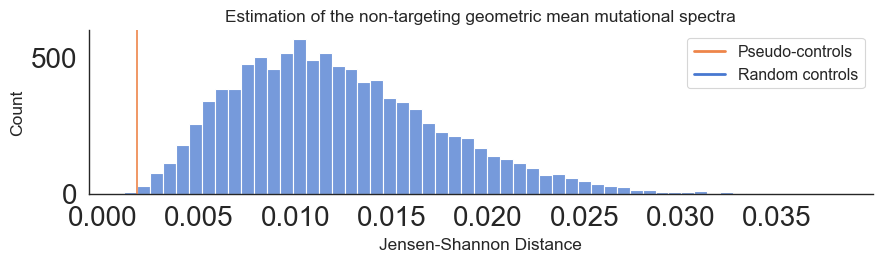

In [27]:
bootstrapped_means = pkl.load(open("../exploratory/outlier_analysis/artifacts/jsd_estimates.pkl", "rb"))

jensha_dis = bootstrapped_means["bootstrapped"]
pjsd = bootstrapped_means["pseudo"]
jsd = bootstrapped_means["actual"]

plt.figure(figsize=(9, 2.8))

sns.histplot(jensha_dis)
plt.axvline(pjsd, c=sns.color_palette()[1])
# plt.axvline(jsd, c=sns.color_palette()[1])
plt.ylim(0, 600)
# plt.annotate("Psuedo-\ncontrol\nprofile", (pjsd + 0.0005, 500), c="red")
# plt.annotate("Mean profile", (jsd + 0.0005, 570), c="grey")
plt.title("Estimation of the non-targeting geometric mean mutational spectra")
plt.xlabel("Jensen-Shannon Distance")
plt.ylabel("Count")
custom_lines = [Line2D([0], [0], color=sns.color_palette()[1], lw=2),
                Line2D([0], [0], color=sns.color_palette()[0], lw=2)]
plt.legend(custom_lines, ["Pseudo-controls", "Random controls"], ncols=1, loc="best")
plt.tight_layout()